<a href="https://colab.research.google.com/github/9105507/ProyectoIntegradorIII/blob/main/MODELO_BINARIO_SANO_ENFERMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Proyecto Integrador 3 - Modelo Binario Sano/Enfermo - Grupo 1**
Miguel Ángel Rojo

Miguel Poyatos García-Lorenzana

Jorge Barcenilla González

David Marín Sala

# 1.0 Bibliotecas y funciones utilizadas

In [ ]:
# Bloque 1: Librerías para la descarga del archivo
import zipfile
import io
from io import BytesIO
from PIL import Image, UnidentifiedImageError

# Bloque 2: Librerías para el desarrollo de la Red Neuronal Artificial (RNA)
from keras import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, RMSprop
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import utils
from keras.utils import to_categorical
from keras import backend as K
from keras.models import load_model

# Bloque 3: Librerías para visualización de dataset
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Bloque 4: Librerías para manipulación de datos
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import random

# Bloque 5: Librerías para manejo de imágenes
import cv2
import os

# Bloque 6: Otros
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import gc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, accuracy_score

# Bloque 6: Explicabilidad
from keras.models import Model  # API para definir y entrenar modelos de deep learning
from keras.preprocessing import image  # Herramientas para el preprocesamiento de imágenes
import matplotlib.cm as cm  # Para manejar mapas de colores en matplotlib
from keras.preprocessing.image import img_to_array, load_img  # Herramientas para la carga y conversión de imágenes

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Visualización de la imagen junto con su predicción y resaltando si la predicción es correcta o no:

In [ ]:
def plot_image(indice, predictions, prob_predictions, true_label, img):
    """
    Función para visualizar una imagen junto con su etiqueta predicha y verdadera.

    Parámetros de entrada:
        - indice: Índice de la imagen que se va a mostrar
        - predictions: predicción binaria (0 o 1)
        - prob_predictions: probabilidad de las predicción
        - true_label: Etiqueta verdadera de la imagen
        - img: Matriz que representa la imagen
    """

    # Configuración del gráfico
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Mostrar la imagen
    plt.imshow(img[indice], cmap=plt.cm.binary)

    # Configurar el color del texto según la predicción correcta o incorrecta
    if predictions[indice] == true_label[indice]:
        color = 'green'
    else:
        color = 'red'

    if predictions[indice][0] == 0:
        prob = 1 - prob_predictions[indice][0]
    else:
        prob = prob_predictions[indice][0]

    # Mostrar información sobre la predicción y la etiqueta verdadera
    plt.xlabel("{} [{:1.0f}%]\n({})".format(class_names[predictions[indice][0]],
                                             100*prob,
                                             class_names[true_label[indice]]),
                                             color=color)

Visualización del proceso de aprendizaje de un modelo durante el entrenamiento tanto en los datos de entrenamiento como en los datos de validación:

In [ ]:
def evaluar_rendimiento_validacion(train_loss, train_acc, val_loss, val_acc):
    """
    Evalúa el rendimiento del modelo en términos de pérdida y precisión durante el entrenamiento y la validación.

    Parámetros de entrada:
      - train_loss: Lista de pérdidas en el conjunto de entrenamiento por época.
      - train_acc: Lista de precisión en el conjunto de entrenamiento por época.
      - val_loss: Lista de pérdidas en el conjunto de validación por época.
      - val_acc: Lista de precisión en el conjunto de validación por época.

    La función genera dos gráficas:
      1. Gráfica de Pérdida: Muestra la pérdida de entrenamiento y validación a lo largo de las épocas.
      2. Gráfica de Precisión: Muestra la precisión de entrenamiento y validación a lo largo de las épocas.
    """
    # Configuración de la figura para las gráficas
    fig, axs = plt.subplots(1, 2, figsize=(14, 8))

    # Gráfica de pérdida
    axs[0].plot(range(1, len(train_loss) + 1), train_loss, 'go-', label='Pérdida de entrenamiento')
    axs[0].plot(range(1, len(val_loss) + 1), val_loss, 'ro-', label='Pérdida de validación')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Pérdida')
    axs[0].legend()
    axs[0].set_title('Gráfica de Pérdida')

    # Gráfica de precisión
    axs[1].plot(range(1, len(train_acc) + 1), train_acc,'g-o', label='Precisión de entrenamiento')
    axs[1].plot(range(1, len(val_acc) + 1), val_acc,'ro-', label='Precisión de validación')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Precisión')
    axs[1].legend()
    axs[1].set_title('Gráfica de Precisión')

    # Mostrar las gráficas
    plt.show()

Visualiza en una gráfica la predicción devuelta por el modelo de una imagen como una distribución de probabilidades:

In [ ]:
def plot_value_array(i, predictions, prob_predictions, true_label):
    """
    Visualiza el arreglo de predicciones y resalta la predicción correcta o incorrecta.

    Parámetros de entrada:
      - i: Índice de la muestra en el conjunto de datos.
      - predictions_array: Arreglo de predicciones probabilísticas del modelo.
      - true_label: Etiqueta verdadera de la muestra i.

    La función genera un gráfico de barras que representa las predicciones del modelo para cada clase.

    Si la predicción es correcta, la barra correspondiente a la clase predicha se resalta en verde;
    de lo contrario, se resalta en rojo.

    """
    # Establecer las predicciones y la etiqueta verdadera
    predictions, prob_predictions, true_label = predictions[i][0], prob_predictions[i][0], true_label[i]

    # Configuración del gráfico
    plt.grid(False)
    plt.xticks(range(2))  # Suponemos que hay 2 clases; ajustar si es necesario
    plt.yticks([])

    # Crear un gráfico de barras con colores grises
    thisplot = plt.bar(range(2), [1-prob_predictions, prob_predictions], color="#777777")
    plt.ylim([0, 1])  # Establecer el rango del eje y entre 0 y 1, ya que son probabilidades

    # Resaltar la barra correspondiente a la predicción (verde si es correcta, rojo si es incorrecta)
    if predictions == true_label:
        thisplot[predictions].set_color('green')
    else:
        thisplot[predictions].set_color('red')

Visualiza una matriz de confusión.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Visualiza una matriz de confusión.

    Parámetros de entrada:
      - cm: Matriz de confusión. Debe ser cuadrada y su dimensión debe ser igual al número de clases.
      - classes: Lista de etiquetas de clases.
      - normalize: Indica si la matriz de confusión debe ser normalizada.
      - title: Título de la gráfica.
      - cmap: Mapa de colores a utilizar en la gráfica.

    La función genera una representación visual de la matriz de confusión, resaltando las relaciones entre las
    clases verdaderas y las predicciones del modelo.

    """
    # Configuración de la gráfica
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalizar la matriz de confusión si se especifica
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Configuración de umbrales y texto en las celdas
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Configuración adicional de la gráfica
    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

    # Mostrar la gráfica y limpiar el dibujo actual
    plt.show()
    plt.clf()

# 2.0 Carga y procesado de las imágenes

En primer lugar, se verifica la versión instalada de la biblioteca que estamos utilizando, Tensorflow.

In [ ]:
if tf.__version__ < "2.0.0":
  print('La versión de tensorflow no es la adecuada')

print(tf.__version__)

2.15.0


### 2.1 Carga de las imágenes

Se pide permiso al usuario a acceder a Google Drive con el fin de acceder a los datos del proyecto:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**PRIMER DATA SET:** [Fuente1](https://www.sciencedirect.com/science/article/pii/S0092867418301545?via%3Dihub#sec4) [Fuente2](https://data.mendeley.com/datasets/rscbjbr9sj/2)

In [ ]:
# archivo_zip = '/content/drive/MyDrive/Ingeniería Matemática/Proyecto Integrador III/Proyecto III/ChestXRay2017.zip' #Direccion Miguel
archivo_zip = '/content/drive/MyDrive/Proyecto III/ChestXRay2017.zip' #Dirección Mike

# Si no está instalada la librería 'pillow', descomentar esto:
#!pip install pillow

# Lectura del archivo zip
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    # Extract the contents of the ZIP file
    zip_ref.extractall('/content/')

    # Lista de nombres de archivos en el archivo ZIP
    file_list = zip_ref.namelist()

# Visualización de la variable 'file_list':
file_list[500:505]

# Hay una copia que falla y es macosx, la quitamos
# PENDIENTE DE QUITAR A MANO
file_list = [nombre for nombre in file_list if 'MACOSX' not in nombre]

# Se comprueba que se tienen los archivos correspondientes:
os.listdir('/content/')

# Se crean listas para almacenar los datos de las imágenes y las etiquetas
images = []
labels = []

# Se leen y guardan los datos con el siguiente código:
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    for file_info in file_list:
        # Se verifica que el archivo sea una imagen JPEG
        if file_info.lower().endswith('.jpeg') or file_info.lower().endswith('.jpg'):

            # Comprobamos la etiqueta
            if 'bacteria' in file_info or 'virus' in file_info:
              label = 1 # ESTÁ ENFERMO
            else:
              label = 0 # ES NORMAL

            # if file_info in malas:
            #   continue # Saltar
            # # if file_info in '__MACOSX/chest_xray/test/PNEUMONIA/._person48_virus_100.jpeg':
            # #   break # Parar
            # if 'MACOSX' in file_info:
            #   continue # Saltar

            # Se lee y procesa cada imagen en el archivo ZIP
            with zip_ref.open(file_info) as file:
                img = Image.open(BytesIO(file.read()))
                img = img.resize((128, 128))  # Ajusta el tamaño según sea necesario

                # Se convierte la imagen a escala de grises
                img = img.convert('L')

                # Pasamos de PIL a ARRAY
                img_array = np.array(img)

                # Se invierten los colores de la imagen
                img_array = np.invert(img_array)

                # Se agregan los datos de la imagen y la etiqueta a las listas
                images.append(img_array)
                labels.append(label)

# Se convierte las listas en arrays de NumPy
images = np.array(images)
labels = np.array(labels)

# Se realiza el reshape para agregar la dimensión adicional necesaria más adelante
images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))

# Se comprueba el tamaño de los datos
print(images.shape)
print(labels.shape)

# Liberamos memoria
del img
del img_array
del label

(5856, 128, 128, 1)
(5856,)


**SEGUNDO DATA SET:**

In [ ]:
# archivo_zip = '/content/drive/MyDrive/Ingeniería Matemática/Proyecto Integrador III/Proyecto III/ChestXRay2017.zip' #Direccion Miguel
archivo_zip = '/content/drive/MyDrive/Proyecto III/3kinds.zip' #Dirección Mike

# Si no está instalada la librería 'pillow', descomentar esto:
#!pip install pillow

# Lectura del archivo zip
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    # Extract the contents of the ZIP file
    zip_ref.extractall('/content/')

    # Lista de nombres de archivos en el archivo ZIP
    file_list = zip_ref.namelist()

# Visualización de la variable 'file_list':
file_list[500:505]

#Solo queremos las imágenes de neumonía
# PENDIENTE DE QUITAR A MANO
file_list = [nombre for nombre in file_list if 'COVID-19' not in nombre]

# Se comprueba que se tienen los archivos correspondientes:
os.listdir('/content/')

# Se crean listas para almacenar los datos de las imágenes y las etiquetas
images2 = []
labels2 = []

# Se leen y guardan los datos con el siguiente código:
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    for file_info in file_list:
        # Se verifica que el archivo sea una imagen JPEG
        if file_info.lower().endswith('.jpeg') or file_info.lower().endswith('.jpg'):

            # Comprobamos la etiqueta
            if 'Bacterial' in file_info or 'Viral' in file_info:
              label = 1 # ESTÁ ENFERMO
            else:
              label = 0 # ES NORMAL

            # if file_info in malas:
            #   continue # Saltar
            # # if file_info in '__MACOSX/chest_xray/test/PNEUMONIA/._person48_virus_100.jpeg':
            # #   break # Parar
            # if 'MACOSX' in file_info:
            #   continue # Saltar

            # Se lee y procesa cada imagen en el archivo ZIP
            with zip_ref.open(file_info) as file:
                img = Image.open(BytesIO(file.read()))
                img = img.resize((128, 128))  # Ajusta el tamaño según sea necesario

                # Se convierte la imagen a escala de grises
                img = img.convert('L')

                # Pasamos de PIL a ARRAY
                img_array = np.array(img)

                # Se invierten los colores de la imagen
                img_array = np.invert(img_array)

                # Se agregan los datos de la imagen y la etiqueta a las listas
                images2.append(img_array)
                labels2.append(label)

# Se convierte las listas en arrays de NumPy
images2 = np.array(images2)
labels2 = np.array(labels2)

# Se realiza el reshape para agregar la dimensión adicional necesaria más adelante
images2 = np.reshape(images2, (images2.shape[0], images2.shape[1], images2.shape[2], 1))

# Se comprueba el tamaño de los datos
print(images2.shape)
print(labels2.shape)

# Liberamos memoria
del img
del img_array
del label

(7927, 128, 128, 1)
(7927,)


**unimos todas las imágenes en un único dataset:**

In [ ]:
dataset_images = np.concatenate((images, images2), axis=0)
dataset_labels = np.concatenate((labels, labels2), axis=0)
print(dataset_images.shape)
print(dataset_labels.shape)

(13783, 128, 128, 1)
(13783,)


**y liberamos memoria:**

In [ ]:
# del images, labels, images2, labels2#, images3, labels3
del file, file_info, file_list, zip_ref, archivo_zip

### 2.2 Visualización de imágenes:

In [ ]:
# Listas necesarias para la visualización de datos
# class_names_1 = ['Normal',
#                'Bacterial Pneumonia',
#                'Viral Pneumonia']
class_names = ['Normal',
               'Pneumonia']
# class_names_2 = ['Bacterial Pneumonia',
#                'Viral Pneumonia']

Se visualizan 4 imágenes aleatorias de nuestra base de datos junto con sus resectivas clases:

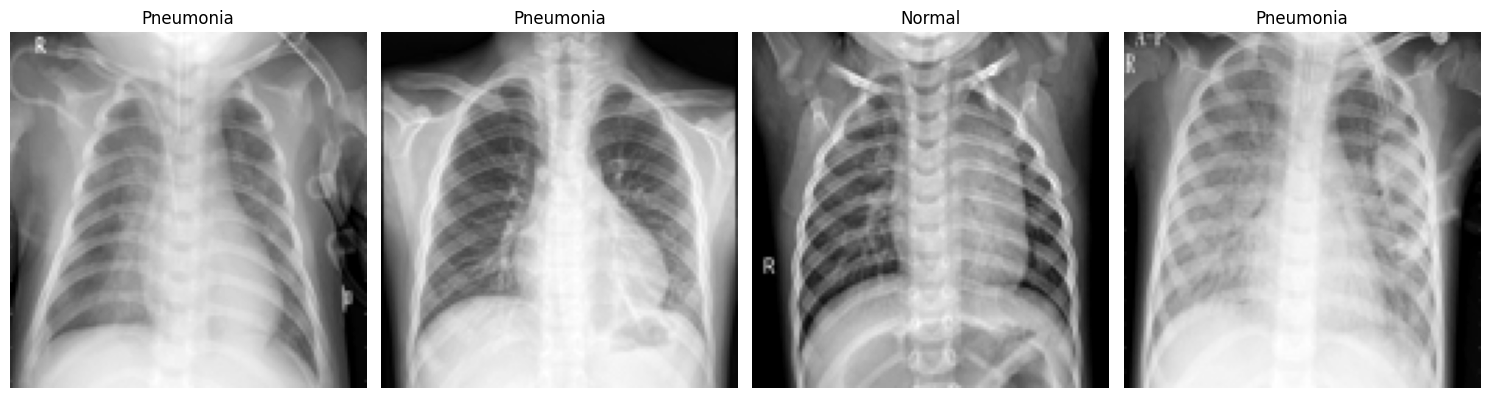

In [ ]:
import matplotlib.pyplot as plt

# Generar 4 números aleatorios
num_images = np.random.randint(0, len(dataset_images), 4)
# print(num_images)

# Crea un subplot con 2 columnas y la cantidad de filas necesarias
fig, axes = plt.subplots(1, len(num_images), figsize=(15, 5))

# Itera sobre las primeras imágenes elegidas aleatoriamente y sus etiquetas
for i in range(len(num_images)):
    axes[i].imshow(dataset_images[num_images[i]], cmap=plt.cm.binary)
    axes[i].set_title(class_names[dataset_labels[num_images[i]]])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Liberamos memoria
del num_images

También, se muestran 25 imágenes aleatorias con sus respectivas clases:

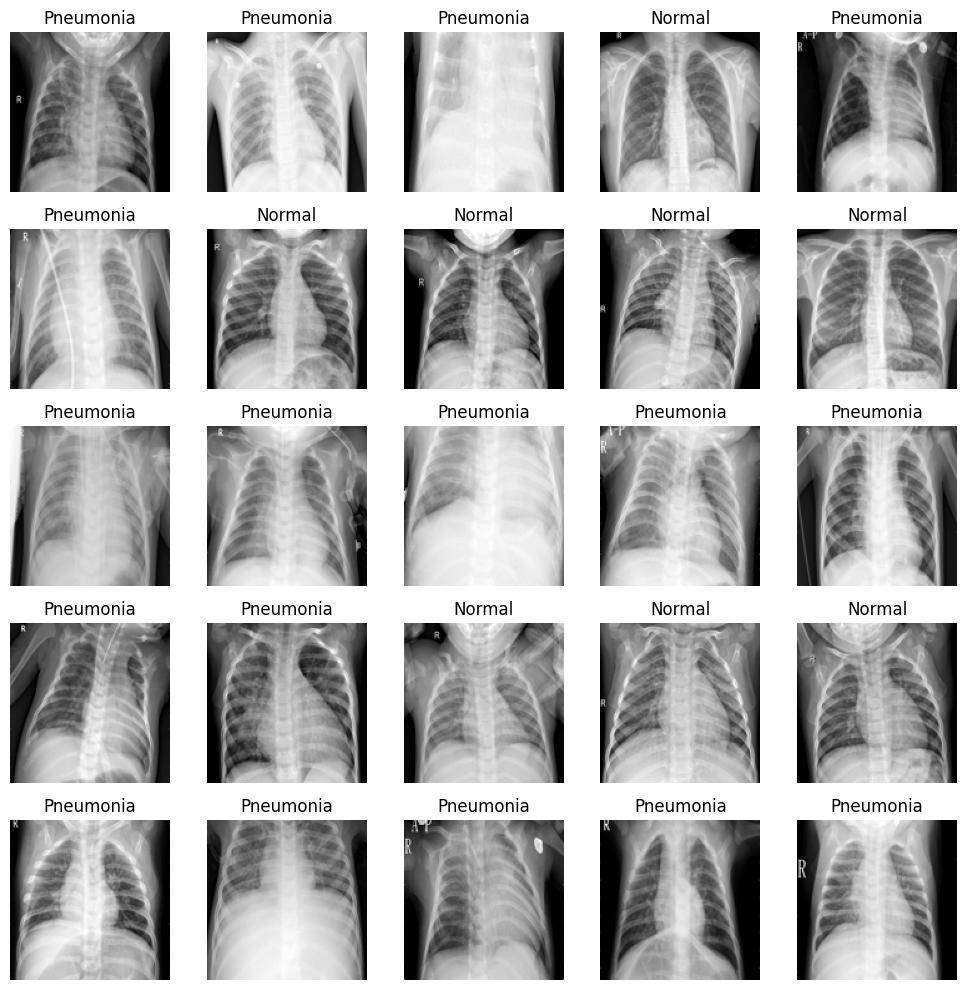

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))

# Rellenar el subplot con imágenes aleatorias
for i in range(5):
    for j in range(5):
        # Seleccionar un índice aleatorio
        idx = np.random.randint(len(dataset_images))
        # Mostrar la imagen correspondiente en el subplot
        axes[i, j].imshow(dataset_images[idx], cmap=plt.cm.binary)
        axes[i,j].set_title(class_names[dataset_labels[idx]])
        # Eliminar los ejes para una mejor visualización
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# Liberamos memoria
del idx

In [ ]:
index_count = Counter(dataset_labels)
sorted_indices = sorted(index_count.items())
for index, count in sorted_indices:
    print(f'{class_names[index]}: {count}')

# Liberamos memoria
del index_count
del sorted_indices

Normal: 4853
Pneumonia: 8930


### 2.3 Preparar y normalizar imágenes

A continuación, se realiza la división de todo el conjunto en uno del tipo 'train - validation - test':

In [ ]:
# Primero, divide los datos en conjuntos de entrenamiento y temporal (que luego se dividirá en validación y prueba)
X, test_X, y, test_y = train_test_split(dataset_images, dataset_labels,
                                        test_size=0.2,
                                        random_state=89,
                                        shuffle=True,
                                        stratify=dataset_labels)

# Luego, divide los datos temporales en conjuntos de validación y prueba
train_X, val_X, train_y, val_y = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=89,
                                                  shuffle=True,
                                                  stratify=y)

#Liberamos memoria
del dataset_images
del dataset_labels

In [ ]:
index_count = Counter(train_y)
print(" -> TRAIN:")
sorted_indices = sorted(index_count.items())
for index, count in sorted_indices:
    print(f'{class_names[index]}: {count}')

#Liberamos memoria
del index_count
del sorted_indices

 -> TRAIN:
Normal: 3105
Pneumonia: 5715


In [ ]:
index_count = Counter(val_y)
print(" -> VAL:")
sorted_indices = sorted(index_count.items())
for index, count in sorted_indices:
    print(f'{class_names[index]}: {count}')

#Liberamos memoria
del index_count
del sorted_indices

 -> VAL:
Normal: 777
Pneumonia: 1429


In [ ]:
index_count = Counter(test_y)
print(" -> TEST:")
sorted_indices = sorted(index_count.items())
for index, count in sorted_indices:
    print(f'{class_names[index]}: {count}')

#Liberamos memoria
del index_count
del sorted_indices

 -> TEST:
Normal: 971
Pneumonia: 1786


In [ ]:
# Se normalizan los datos:
train_X = train_X.astype('float32')/255
val_X = val_X.astype('float32')/255
test_X = test_X.astype('float32')/255
X = X.astype('float32')/255

# Se convierten las etiquetas a codificación one-hot
# train_y = to_categorical(train_y)
# val_y = to_categorical(val_y)
# test_y_categorical = to_categorical(test_y)
# y = to_categorical(y)

# **3.0 Modelo Binario - Detectar Neumonía**

**EN ESTA CELDA SE ENTRENA EL MODELO DEL TRABAJO ANTERIOR NCON TODOS NUESTROS DATOS: NUEVOS + ANTIGUOS**

In [ ]:
datagentrain = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagentrain.fit(train_X)

**NO VOLVER A EJECUTAR ESTA CELDA**

In [ ]:
binary_model = Sequential()
binary_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Flatten())
binary_model.add(Dense(units = 1024 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 1 , activation = 'sigmoid'))

# Compila el modelo
binary_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

**NO VOLVER A EJECUTAR ESTA CELDA**

Epoch 1/60
276/276 [==============================] - 24s 75ms/step - loss: 0.5945 - accuracy: 0.8288 - val_loss: 7.9953 - val_accuracy: 0.6478 - lr: 0.0010
Epoch 2/60
276/276 [==============================] - 19s 67ms/step - loss: 0.2526 - accuracy: 0.9043 - val_loss: 1.1944 - val_accuracy: 0.7752 - lr: 0.0010
Epoch 3/60
276/276 [==============================] - 20s 72ms/step - loss: 0.2155 - accuracy: 0.9228 - val_loss: 0.1245 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 4/60
276/276 [==============================] - 19s 68ms/step - loss: 0.1963 - accuracy: 0.9348 - val_loss: 0.5009 - val_accuracy: 0.8019 - lr: 0.0010
Epoch 5/60
276/276 [==============================] - 21s 75ms/step - loss: 0.1860 - accuracy: 0.9373 - val_loss: 0.2165 - val_accuracy: 0.9406 - lr: 0.0010
Epoch 6/60
276/276 [==============================] - 18s 66ms/step - loss: 0.1679 - accuracy: 0.9427 - val_loss: 1.0735 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 7/60
276/276 [==============================] - 19s 

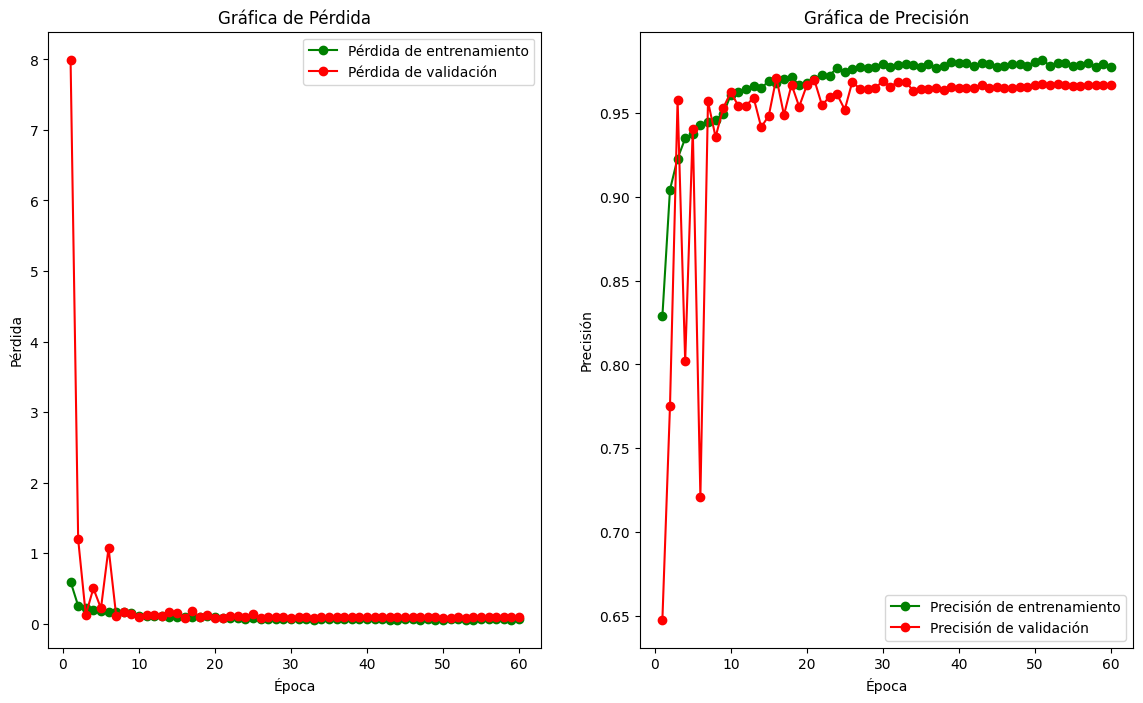

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 6,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.00000001)

# Define ModelCheckpoint callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(filepath='best_model.keras',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max')

class_weights = compute_class_weight("balanced", classes=np.unique(train_y), y=train_y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

history = binary_model.fit(datagentrain.flow(train_X,train_y, batch_size = 32),
                    epochs = 60 , validation_data = (val_X,val_y),
                    callbacks = [learning_rate_reduction, model_checkpoint], class_weight=class_weights_dict)

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

print('\n RENDIMIENTO ENTRENAMIENTO:')
evaluar_rendimiento_validacion(train_loss,train_acc, val_loss, val_acc)

**CÓDIGO QUE RECUPERA EL MEJOR MODELO QUE SE GUARDÓ DURANTE EL ENTRENAMIENTO**

In [ ]:
# Cargar el modelo guardado
binary_model = load_model('best_model_validation.keras')

Se evalua con los datos de prueba:

In [ ]:
test_loss, test_acc = binary_model.evaluate(test_X, test_y, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9677185416221619


**SI QUISIESEMOS ENTRENAR CON TODOS LOS DATOS, UTILIZAR ESTE CALLBACK:**

In [ ]:
class LearningRateMultiplier(Callback):
    def __init__(self, epoch_to_multiply, lr_multiplier):
        super().__init__()
        self.epoch_to_multiply = epoch_to_multiply
        self.lr_multiplier = lr_multiplier

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epoch_to_multiply:
            old_lr = float(K.get_value(self.model.optimizer.lr))
            new_lr = old_lr * self.lr_multiplier
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f"\nChanged learning rate from {old_lr} to {new_lr} at epoch {epoch + 1}\n")

# Crear el callback para cambiar la tasa de aprendizaje en la época 23 multiplicándola por 0.3.
cambio_lr_callback = LearningRateMultiplier(epoch_to_multiply=[8], lr_multiplier=0.3)

In [ ]:
binary_model = Sequential()
binary_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Flatten())
binary_model.add(Dense(units = 1024 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 1 , activation = 'sigmoid'))

# Compila el modelo
binary_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

**NO VOLVER A EJECUTAR ESTO**

In [ ]:
datagentrain = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagentrain.fit(X)
class_weights = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

binary_model.fit(datagentrain.flow(X,y, batch_size = 32),
                    epochs = 16,
                    callbacks = [cambio_lr_callback], class_weight=class_weights_dict)

Epoch 1/16
345/345 [==============================] - 27s 70ms/step - loss: 0.4639 - accuracy: 0.8618
Epoch 2/16
345/345 [==============================] - 25s 71ms/step - loss: 0.2328 - accuracy: 0.9211
Epoch 3/16
345/345 [==============================] - 23s 65ms/step - loss: 0.2025 - accuracy: 0.9313
Epoch 4/16
345/345 [==============================] - 24s 70ms/step - loss: 0.1736 - accuracy: 0.9383
Epoch 5/16
345/345 [==============================] - 24s 70ms/step - loss: 0.1686 - accuracy: 0.9417
Epoch 6/16
345/345 [==============================] - 24s 70ms/step - loss: 0.1543 - accuracy: 0.9457
Epoch 7/16
345/345 [==============================] - 24s 69ms/step - loss: 0.1600 - accuracy: 0.9457
Epoch 8/16
345/345 [==============================] - 24s 69ms/step - loss: 0.1479 - accuracy: 0.9505

Changed learning rate from 0.0010000000474974513 to 0.0003000000142492354 at epoch 9

Epoch 9/16
345/345 [==============================] - 25s 71ms/step - loss: 0.1140 - accuracy: 0.

**NO VOLVER A EJECUTAR ESTO**

In [ ]:
binary_model.save('best_model_wholedataset.keras')

**RECUPERACIÓN DEL MODELO ENTRENADO CON TODO EL DATASET DE ENTRENAMIENTO**

In [ ]:
# Cargar el modelo guardado
binary_model = load_model('best_model_wholedataset.keras')

In [ ]:
test_loss, test_acc = binary_model.evaluate(test_X, test_y, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9677185416221619


**AHORA VOY A HACER LO QUE ME DIJO POYATOS, ES DECIR:**
 - **ENTRENAR MODELO CON DATOS DE PROYECTO ANTERIOR**
 - **PASAR A ESTE MODELO LOS 8000 NUEVOS DATOS DE LA NUEVA BASE DE DATOS Y VER QUE TAN BIEN CLASIFICA**
 - **ENTRENAR MODELO CON DATOS NUEVOS (DATASER DE JORGE)**
 - **PASAR A ESTE MODELO LOS 6000 DATOS ANTIGUOS (PROYECTO ANTERIOR) DE LA NUEVA BASE DE DATOS Y VER QUE TAN BIEN CLASIFICA**
 - **ENTRENAR MODELO CON TODOS LOS DATOS (YA ESTÁ HECHO)**
 - **CREAR TABLA COMPARATIVA QUE REFLEJE LA MEJORA DEL MODELO**

In [ ]:
# Primero, divide los datos en conjuntos de entrenamiento y temporal (que luego se dividirá en validación y prueba)
X, test_X, y, test_y = train_test_split(images, labels,#datos del dataset del proyecto anterior
                                        test_size=0.2,
                                        random_state=89,
                                        shuffle=True,
                                        stratify=labels)

# Luego, divide los datos temporales en conjuntos de validación y prueba
train_X, val_X, train_y, val_y = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=89,
                                                  shuffle=True,
                                                  stratify=y)
# Se normalizan los datos:
train_X = train_X.astype('float32')/255
val_X = val_X.astype('float32')/255
test_X = test_X.astype('float32')/255
X = X.astype('float32')/255

In [ ]:
class LearningRateMultiplier(Callback):
    def __init__(self, epoch_to_multiply, lr_multiplier):
        super().__init__()
        self.epoch_to_multiply = epoch_to_multiply
        self.lr_multiplier = lr_multiplier

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epoch_to_multiply:
            old_lr = float(K.get_value(self.model.optimizer.lr))
            new_lr = old_lr * self.lr_multiplier
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f"\nChanged learning rate from {old_lr} to {new_lr} at epoch {epoch + 1}\n")

# Crear el callback para cambiar la tasa de aprendizaje en la época 23 multiplicándola por 0.3.
cambio_lr_callback = LearningRateMultiplier(epoch_to_multiply=[16, 28, 37], lr_multiplier=0.3)

In [ ]:
binary_model = Sequential()
binary_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Flatten())
binary_model.add(Dense(units = 1024 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 1 , activation = 'sigmoid'))

# Compila el modelo
binary_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

**NO VOLVER A EJECUTAR ESTO**

In [ ]:
datagentrain = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagentrain.fit(X)

class LearningRateMultiplier(Callback):
    def __init__(self, epoch_to_multiply, lr_multiplier):
        super().__init__()
        self.epoch_to_multiply = epoch_to_multiply
        self.lr_multiplier = lr_multiplier

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epoch_to_multiply:
            old_lr = float(K.get_value(self.model.optimizer.lr))
            new_lr = old_lr * self.lr_multiplier
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f"\nChanged learning rate from {old_lr} to {new_lr} at epoch {epoch + 1}\n")

# Crear el callback para cambiar la tasa de aprendizaje en la época 23 multiplicándola por 0.3.
cambio_lr_callback = LearningRateMultiplier(epoch_to_multiply=[16, 28, 37], lr_multiplier=0.3)

class_weights = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

binary_model.fit(datagentrain.flow(X,y, batch_size = 32),
                    epochs = 43,
                    callbacks = [cambio_lr_callback], class_weight=class_weights_dict)

Epoch 1/43
  5/147 [>.............................] - ETA: 6s - loss: 7.0401 - accuracy: 0.4750 

147/147 [==============================] - 20s 99ms/step - loss: 0.7294 - accuracy: 0.7953
Epoch 2/43
147/147 [==============================] - 15s 105ms/step - loss: 0.3276 - accuracy: 0.8732
Epoch 3/43
147/147 [==============================] - 14s 97ms/step - loss: 0.2833 - accuracy: 0.8941
Epoch 4/43
147/147 [==============================] - 9s 62ms/step - loss: 0.2493 - accuracy: 0.9105
Epoch 5/43
147/147 [==============================] - 9s 62ms/step - loss: 0.2409 - accuracy: 0.9155
Epoch 6/43
147/147 [==============================] - 10s 70ms/step - loss: 0.2220 - accuracy: 0.9281
Epoch 7/43
147/147 [==============================] - 10s 69ms/step - loss: 0.2084 - accuracy: 0.9234
Epoch 8/43
147/147 [==============================] - 9s 60ms/step - loss: 0.2208 - accuracy: 0.9283
Epoch 9/43
147/147 [==============================] - 10s 68ms/step - loss: 0.1942 - accuracy: 0.9306
Epoch 10/43
147/147 [==============================] - 11s 75ms/step - loss: 0.2025 - accuracy:

**NO VOLVER A EJECUTAR ESTO**

In [ ]:
binary_model.save('best_old_model.keras')

**RECUPERACIÓN DEL MODELO ENTRENADO CON TODO EL DATASET DE ENTRENAMIENTO ANTIGUO**

In [ ]:
# Cargar el modelo guardado
binary_model = load_model('best_old_model.keras')

In [ ]:
test_loss, test_acc = binary_model.evaluate(test_X, test_y, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9325938820838928


**AHORA LE PASAMOS A ESTE MODELO, EL NUEVO DATASET**

In [ ]:
images2 = images2.astype('float32')/255

In [ ]:
test_loss, test_acc = binary_model.evaluate(images2, labels2, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9525671601295471


**ERA UN BUEN MODELO!!**

In [ ]:
# Primero, divide los datos en conjuntos de entrenamiento y temporal (que luego se dividirá en validación y prueba)
X, test_X, y, test_y = train_test_split(images2, labels2,#datos del dataset del proyecto anterior
                                        test_size=0.2,
                                        random_state=89,
                                        shuffle=True,
                                        stratify=labels2)

# Luego, divide los datos temporales en conjuntos de validación y prueba
train_X, val_X, train_y, val_y = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=89,
                                                  shuffle=True,
                                                  stratify=y)

In [ ]:
class LearningRateMultiplier(Callback):
    def __init__(self, epoch_to_multiply, lr_multiplier):
        super().__init__()
        self.epoch_to_multiply = epoch_to_multiply
        self.lr_multiplier = lr_multiplier

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epoch_to_multiply:
            old_lr = float(K.get_value(self.model.optimizer.lr))
            new_lr = old_lr * self.lr_multiplier
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f"\nChanged learning rate from {old_lr} to {new_lr} at epoch {epoch + 1}\n")

# Crear el callback para cambiar la tasa de aprendizaje en la época 23 multiplicándola por 0.3.
cambio_lr_callback = LearningRateMultiplier(epoch_to_multiply=[16, 28, 37], lr_multiplier=0.3)

In [ ]:
binary_model = Sequential()
binary_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(BatchNormalization())
binary_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
binary_model.add(Flatten())
binary_model.add(Dense(units = 1024 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 512 , activation = 'relu'))
binary_model.add(Dropout(0.1))
binary_model.add(Dense(units = 1 , activation = 'sigmoid'))

# Compila el modelo
binary_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

**NO VOLVER A EJECUTAR ESTO**

In [ ]:
datagentrain = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagentrain.fit(X)

class LearningRateMultiplier(Callback):
    def __init__(self, epoch_to_multiply, lr_multiplier):
        super().__init__()
        self.epoch_to_multiply = epoch_to_multiply
        self.lr_multiplier = lr_multiplier

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epoch_to_multiply:
            old_lr = float(K.get_value(self.model.optimizer.lr))
            new_lr = old_lr * self.lr_multiplier
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f"\nChanged learning rate from {old_lr} to {new_lr} at epoch {epoch + 1}\n")

# Crear el callback para cambiar la tasa de aprendizaje en la época 23 multiplicándola por 0.3.
cambio_lr_callback = LearningRateMultiplier(epoch_to_multiply=[16, 28, 37], lr_multiplier=0.3)

class_weights = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

binary_model.fit(datagentrain.flow(X,y, batch_size = 32),
                    epochs = 43,
                    callbacks = [cambio_lr_callback], class_weight=class_weights_dict)

Epoch 1/43
199/199 [==============================] - 20s 85ms/step - loss: 0.5913 - accuracy: 0.8384
Epoch 2/43
199/199 [==============================] - 22s 109ms/step - loss: 0.2613 - accuracy: 0.9087
Epoch 3/43
199/199 [==============================] - 13s 66ms/step - loss: 0.2160 - accuracy: 0.9197
Epoch 4/43
199/199 [==============================] - 13s 66ms/step - loss: 0.1967 - accuracy: 0.9308
Epoch 5/43
199/199 [==============================] - 13s 67ms/step - loss: 0.1775 - accuracy: 0.9371
Epoch 6/43
199/199 [==============================] - 13s 66ms/step - loss: 0.1765 - accuracy: 0.9415
Epoch 7/43
199/199 [==============================] - 13s 65ms/step - loss: 0.1665 - accuracy: 0.9445
Epoch 8/43
199/199 [==============================] - 13s 67ms/step - loss: 0.1568 - accuracy: 0.9484
Epoch 9/43
199/199 [==============================] - 13s 67ms/step - loss: 0.1420 - accuracy: 0.9503
Epoch 10/43
199/199 [==============================] - 13s 66ms/step - loss: 0.14

**NO VOLVER A EJECUTAR ESTO**

In [ ]:
binary_model.save('best_new_model.keras')

**RECUPERACIÓN DEL MODELO ENTRENADO CON TODO EL DATASET DE ENTRENAMIENTO NUEVO**

In [ ]:
# Cargar el modelo guardado
binary_model = load_model('best_new_model.keras')

In [ ]:
test_loss, test_acc = binary_model.evaluate(test_X, test_y, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9627994894981384


**AHORA LE PASAMOS A ESTE MODELO, EL DATASET ANTERIOR**

In [ ]:
images = images.astype('float32')/255

In [ ]:
test_loss, test_acc = binary_model.evaluate(images, labels, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9600409865379333


**BUEN MODELO !!**

**TABLA COMPARATIVA EVOLUCIÓN:**

| Modelo    | Datos Entrenamiento | Test Accuracy | Accuracy con dataset complementario|
|-----------|---------------------|---------------|--------------|
| 1         |  OLD                | 93.26 %       | 95.26 %      |
| 2         |  NEW                | 96.28 %       | 96.00 %      |
| 3         |  OLD + NEW          | 96.77 %       |    -         |


**CONCLUSIONES:**
 - **NUEVA BASE DE DATOS MEJOR QUE LA ANTERIOR**
 - **JUNTAS MEJOR**
 - **NO OBSTANTE, TODOS LOS MODELOS SON BUENOS**

# 4.0 Registro y análisis de los resultados

## 4.1 Precisión de test

**SUBIR EL MODELO DEL QUE SE QUIERE ANALIZAR LOS RESULTADOS**

In [ ]:
# Cargar el modelo guardado
binary_model = load_model('best_model_validation.keras')

In [ ]:
test_loss, test_acc = binary_model.evaluate(test_X, test_y, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9677185416221619


## **CURVA ROC**

87/87 [==============================] - 43s 492ms/step


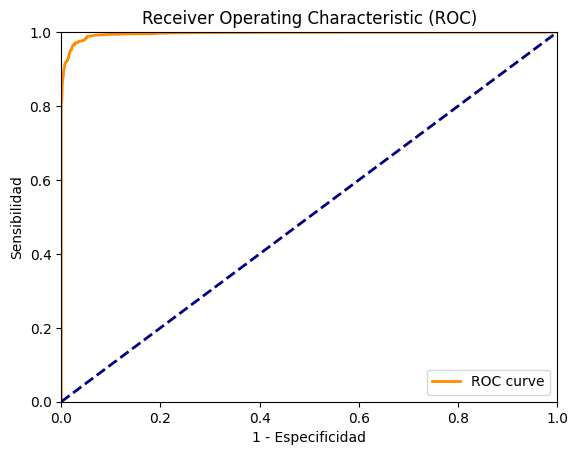


Umbral óptimo que maximiza el índice de Youden: 0.40284914


In [ ]:
# Predecimos la etiqueta utilizando el modelo final
predictions = binary_model.predict(test_X)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

# Definir los valores de sensibilidad y especificidad para almacenar los resultados
sensitivities = []
specificities = []

# Calcular las sensibilidades y especificidades para diferentes umbrales
for threshold in thresholds:
    # Convertir las probabilidades predichas a etiquetas binarias usando el umbral actual
    binary_predictions = (predictions > threshold).astype(int)

    # Calcular las métricas de sensibilidad y especificidad
    tn, fp, fn, tp = confusion_matrix(test_y, binary_predictions).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Agregar las métricas a las listas correspondientes
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Convertir las listas a matrices numpy para facilitar su manipulación
sensitivities = np.array(sensitivities)
specificities = np.array(specificities)

# Plotear la curva ROC usando sensibilidad y especificidad
plt.figure()
plt.plot(1 - specificities, sensitivities, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calcular el índice de Youden para cada umbral
youden_index = sensitivities + specificities - 1

# Encontrar el umbral que maximiza el índice de Youden
optimal_threshold = thresholds[np.argmax(youden_index)]

# Mostrar el umbral óptimo
print("\nUmbral óptimo que maximiza el índice de Youden:", optimal_threshold)

## 4.2 Classification report

In [ ]:
# Predecimos la etiqueta utilizando el modelo final
predictions = binary_model.predict(test_X)
# Convertir las predicciones a etiquetas enteras
predictions_binary_1 = (predictions > optimal_threshold).astype(int) #CON PUNTO DE CORTE ÓPTIMO
predictions_binary_2 = np.round(predictions).astype(int) #CON PUNTO DE CORTE = 0.5

# Contar cuántas predicciones son correctas
print("\nMODELO 1, PUNTO DE CORTE = ", optimal_threshold)
correct_predictions_vector = []
for i in range(predictions_binary_1.shape[0]):
  correct_predictions_vector.append(predictions_binary_1[i] == test_y[i])
correct_predictions_vector = np.array(correct_predictions_vector)
correct_predictions = np.sum(correct_predictions_vector)

print(f'Número de predicciones correctas: {correct_predictions}')
print(f'Número de predicciones totales: {len(predictions_binary_1)}')

# Contar cuántas predicciones son correctas
print("\nMODELO 2, PUNTO DE CORTE = ", 0.5)
correct_predictions_vector = []
for i in range(predictions_binary_2.shape[0]):
  correct_predictions_vector.append(predictions_binary_2[i] == test_y[i])
correct_predictions_vector = np.array(correct_predictions_vector)
correct_predictions = np.sum(correct_predictions_vector)

print(f'Número de predicciones correctas: {correct_predictions}')
print(f'Número de predicciones totales: {len(predictions_binary_2)}')

87/87 [==============================] - 48s 543ms/step

MODELO 1, PUNTO DE CORTE =  0.40284914
Número de predicciones correctas: 2678
Número de predicciones totales: 2757

MODELO 2, PUNTO DE CORTE =  0.5
Número de predicciones correctas: 2668
Número de predicciones totales: 2757


In [ ]:
print("\nMODELO 1, PUNTO DE CORTE = ", optimal_threshold)
print(classification_report(test_y, predictions_binary_1, target_names = ['Normal (Class 0)','Enfermo (Class 1)']))

print("\nMODELO 2, PUNTO DE CORTE = ", 0.5)
print(classification_report(test_y, predictions_binary_2, target_names = ['Normal (Class 0)','Enfermo (Class 1)']))


MODELO 1, PUNTO DE CORTE =  0.40284914
                   precision    recall  f1-score   support

 Normal (Class 0)       0.95      0.97      0.96       971
Enfermo (Class 1)       0.98      0.97      0.98      1786

         accuracy                           0.97      2757
        macro avg       0.97      0.97      0.97      2757
     weighted avg       0.97      0.97      0.97      2757


MODELO 2, PUNTO DE CORTE =  0.5
                   precision    recall  f1-score   support

 Normal (Class 0)       0.93      0.98      0.96       971
Enfermo (Class 1)       0.99      0.96      0.97      1786

         accuracy                           0.97      2757
        macro avg       0.96      0.97      0.96      2757
     weighted avg       0.97      0.97      0.97      2757



In [ ]:
# Calcular la precisión utilizando las etiquetas binarias y las etiquetas verdaderas
precision = accuracy_score(test_y, predictions_binary_1)

print('Precisión en el conjunto de prueba:', precision)

Precisión en el conjunto de prueba: 0.9713456655785274


### Matriz de confusión


MODELO 1, PUNTO DE CORTE =  0.40284914


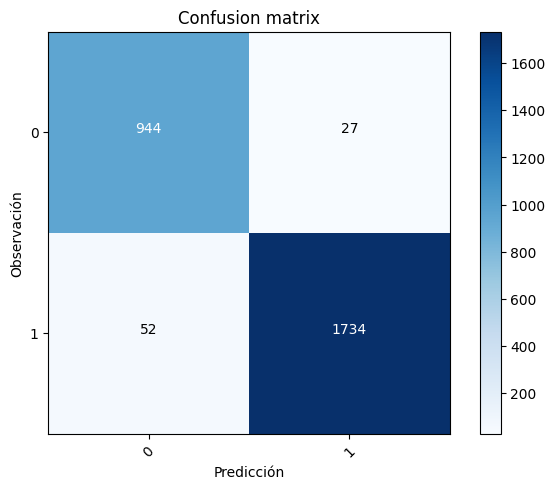


MODELO 2, PUNTO DE CORTE =  0.5


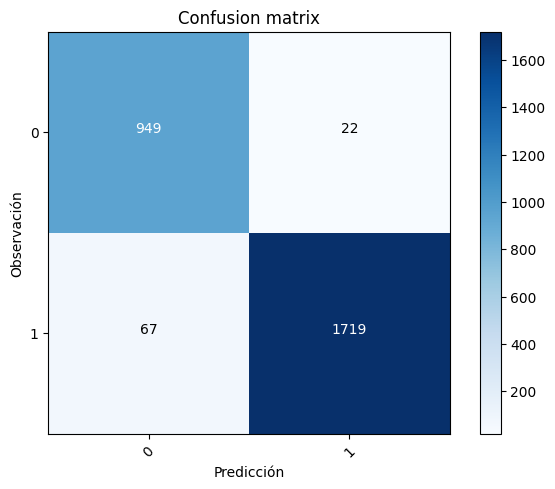

<Figure size 640x480 with 0 Axes>

In [ ]:
print("\nMODELO 1, PUNTO DE CORTE = ", optimal_threshold)
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(test_y, predictions_binary_1)

plot_confusion_matrix(confusion_mtx, classes = range(2))

print("\nMODELO 2, PUNTO DE CORTE = ", 0.5)
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(test_y, predictions_binary_2)

plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
# Cargar el modelo guardado
binary_model = load_model('best_model_wholedataset.keras')

In [ ]:
test_loss, test_acc = binary_model.evaluate(test_X, test_y, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.9677185416221619


## **CURVA ROC**

87/87 [==============================] - 44s 501ms/step


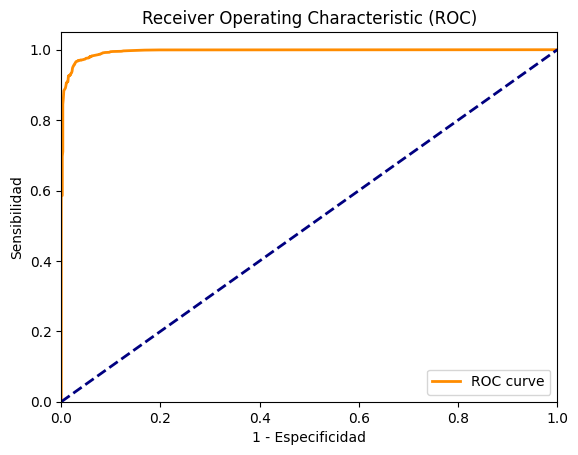


Umbral óptimo que maximiza el índice de Youden: 0.50741255


In [ ]:
# Predecimos la etiqueta utilizando el modelo final
predictions = binary_model.predict(test_X)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

# Definir los valores de sensibilidad y especificidad para almacenar los resultados
sensitivities = []
specificities = []

# Calcular las sensibilidades y especificidades para diferentes umbrales
for threshold in thresholds:
    # Convertir las probabilidades predichas a etiquetas binarias usando el umbral actual
    binary_predictions = (predictions > threshold).astype(int)

    # Calcular las métricas de sensibilidad y especificidad
    tn, fp, fn, tp = confusion_matrix(test_y, binary_predictions).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Agregar las métricas a las listas correspondientes
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Convertir las listas a matrices numpy para facilitar su manipulación
sensitivities = np.array(sensitivities)
specificities = np.array(specificities)

# Plotear la curva ROC usando sensibilidad y especificidad
plt.figure()
plt.plot(1 - specificities, sensitivities, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calcular el índice de Youden para cada umbral
youden_index = sensitivities + specificities - 1

# Encontrar el umbral que maximiza el índice de Youden
optimal_threshold = thresholds[np.argmax(youden_index)]

# Mostrar el umbral óptimo
print("\nUmbral óptimo que maximiza el índice de Youden:", optimal_threshold)

## 4.2 Classification report

In [ ]:
# Predecimos la etiqueta utilizando el modelo final
predictions = binary_model.predict(test_X)
# Convertir las predicciones a etiquetas enteras
predictions_binary_1 = (predictions > optimal_threshold).astype(int) #CON PUNTO DE CORTE ÓPTIMO
predictions_binary_2 = np.round(predictions).astype(int) #CON PUNTO DE CORTE = 0.5

# Contar cuántas predicciones son correctas
print("\nMODELO 1, PUNTO DE CORTE = ", optimal_threshold)
correct_predictions_vector = []
for i in range(predictions_binary_1.shape[0]):
  correct_predictions_vector.append(predictions_binary_1[i] == test_y[i])
correct_predictions_vector = np.array(correct_predictions_vector)
correct_predictions = np.sum(correct_predictions_vector)

print(f'Número de predicciones correctas: {correct_predictions}')
print(f'Número de predicciones totales: {len(predictions_binary_1)}')

# Contar cuántas predicciones son correctas
print("\nMODELO 2, PUNTO DE CORTE = ", 0.5)
correct_predictions_vector = []
for i in range(predictions_binary_2.shape[0]):
  correct_predictions_vector.append(predictions_binary_2[i] == test_y[i])
correct_predictions_vector = np.array(correct_predictions_vector)
correct_predictions = np.sum(correct_predictions_vector)

print(f'Número de predicciones correctas: {correct_predictions}')
print(f'Número de predicciones totales: {len(predictions_binary_2)}')

87/87 [==============================] - 45s 521ms/step

MODELO 1, PUNTO DE CORTE =  0.50741255
Número de predicciones correctas: 2668
Número de predicciones totales: 2757

MODELO 2, PUNTO DE CORTE =  0.5
Número de predicciones correctas: 2668
Número de predicciones totales: 2757


In [ ]:
print("\nMODELO 1, PUNTO DE CORTE = ", optimal_threshold)
print(classification_report(test_y, predictions_binary_1, target_names = ['Normal (Class 0)','Enfermo (Class 1)']))

print("\nMODELO 2, PUNTO DE CORTE = ", 0.5)
print(classification_report(test_y, predictions_binary_2, target_names = ['Normal (Class 0)','Enfermo (Class 1)']))


MODELO 1, PUNTO DE CORTE =  0.50741255
                   precision    recall  f1-score   support

 Normal (Class 0)       0.94      0.97      0.95       971
Enfermo (Class 1)       0.98      0.97      0.97      1786

         accuracy                           0.97      2757
        macro avg       0.96      0.97      0.96      2757
     weighted avg       0.97      0.97      0.97      2757


MODELO 2, PUNTO DE CORTE =  0.5
                   precision    recall  f1-score   support

 Normal (Class 0)       0.94      0.97      0.95       971
Enfermo (Class 1)       0.98      0.97      0.97      1786

         accuracy                           0.97      2757
        macro avg       0.96      0.97      0.96      2757
     weighted avg       0.97      0.97      0.97      2757



In [ ]:
# Calcular la precisión utilizando las etiquetas binarias y las etiquetas verdaderas
precision = accuracy_score(test_y, predictions_binary_1)

print('Precisión en el conjunto de prueba:', precision)

Precisión en el conjunto de prueba: 0.9677185346391005


### Matriz de confusión


MODELO 1, PUNTO DE CORTE =  0.50741255


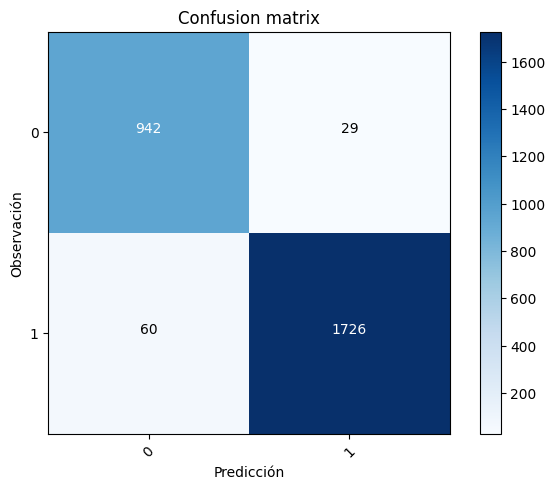


MODELO 2, PUNTO DE CORTE =  0.5


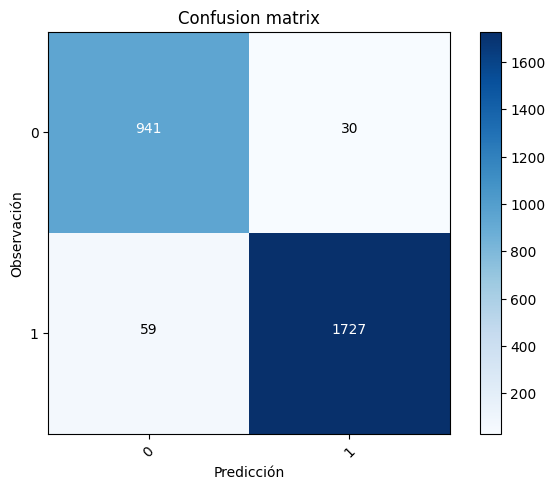

<Figure size 640x480 with 0 Axes>

In [ ]:
print("\nMODELO 1, PUNTO DE CORTE = ", optimal_threshold)
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(test_y, predictions_binary_1)

plot_confusion_matrix(confusion_mtx, classes = range(2))

print("\nMODELO 2, PUNTO DE CORTE = ", 0.5)
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(test_y, predictions_binary_2)

plot_confusion_matrix(confusion_mtx, classes = range(2))

## 4.3 Visualización de las predicciones

Para ver más en detalle que esta pasando, mostramos algunas imagenes de pacientes concretos y vemos como predice el modelo.


MODELO 1, PUNTO DE CORTE =  0.50741255


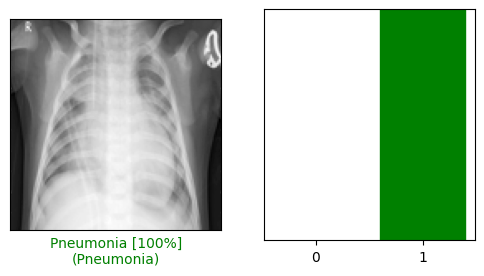

<Figure size 640x480 with 0 Axes>

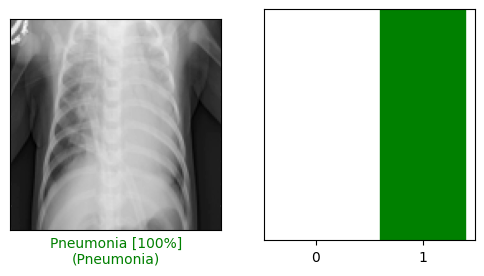

<Figure size 640x480 with 0 Axes>

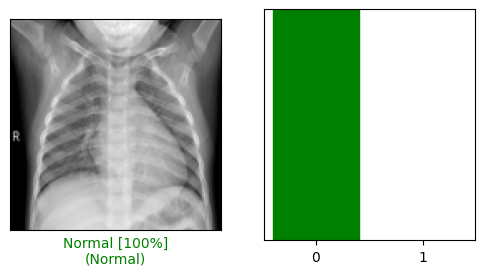

<Figure size 640x480 with 0 Axes>

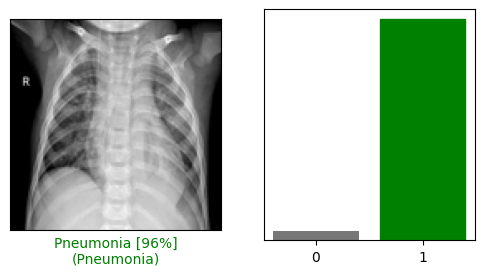

<Figure size 640x480 with 0 Axes>

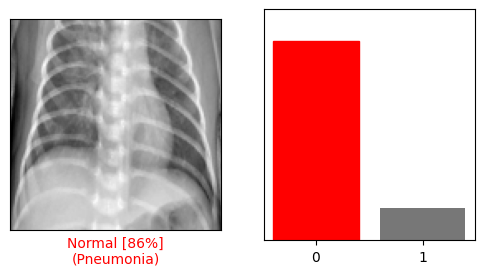

<Figure size 640x480 with 0 Axes>

In [ ]:
print("\nMODELO 1, PUNTO DE CORTE = ", optimal_threshold)
# Selecciona 5 índices aleatorios
indices = np.random.choice(len(predictions_binary_1), 5, replace=False)

for indice in indices:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(indice, predictions_binary_1, predictions, test_y, test_X)
  plt.subplot(1,2,2)
  plot_value_array(indice, predictions_binary_1, predictions,  test_y)
  plt.show()
  plt.clf()


MODELO 2, PUNTO DE CORTE =  0.5


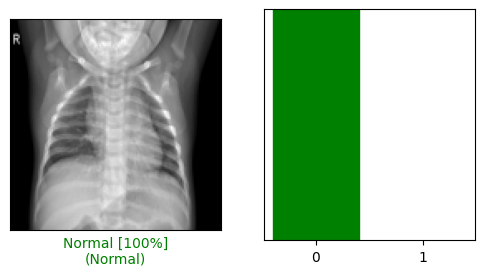

<Figure size 640x480 with 0 Axes>

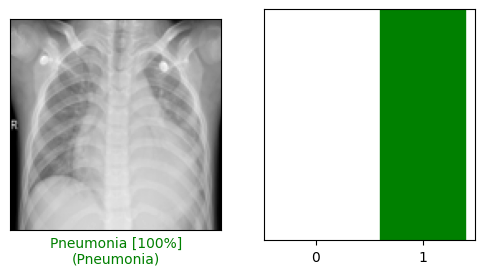

<Figure size 640x480 with 0 Axes>

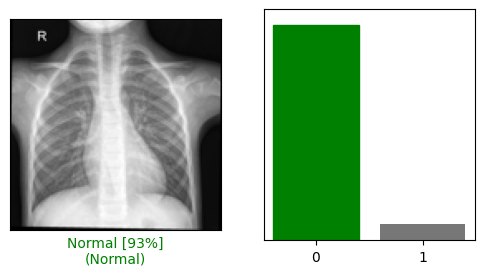

<Figure size 640x480 with 0 Axes>

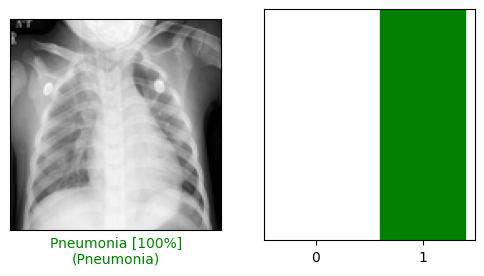

<Figure size 640x480 with 0 Axes>

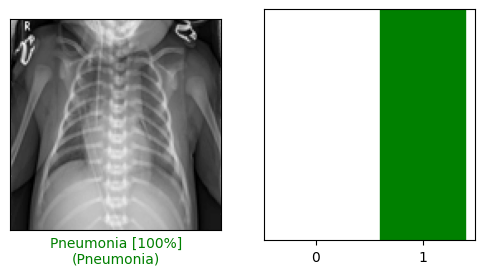

<Figure size 640x480 with 0 Axes>

In [ ]:
print("\nMODELO 2, PUNTO DE CORTE = ", 0.5)
# Selecciona 5 índices aleatorios
indices = np.random.choice(len(predictions_binary_2), 5, replace=False)

for indice in indices:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(indice, predictions_binary_2, predictions, test_y, test_X)
  plt.subplot(1,2,2)
  plot_value_array(indice, predictions_binary_2, predictions,  test_y)
  plt.show()
  plt.clf()

**esto hecho solo con el modelo 2 (que es mejor)**

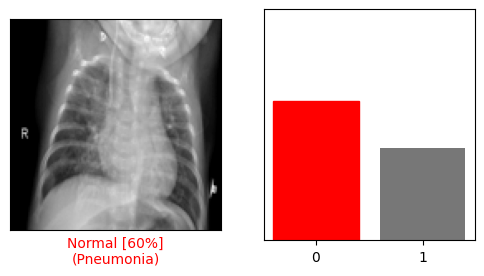

<Figure size 640x480 with 0 Axes>

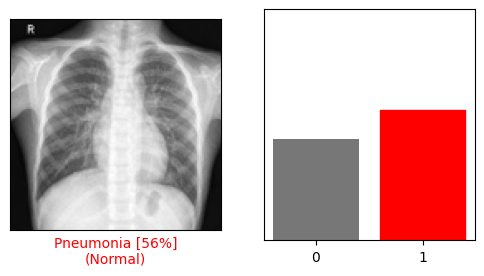

<Figure size 640x480 with 0 Axes>

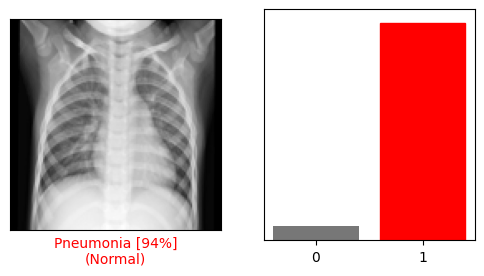

<Figure size 640x480 with 0 Axes>

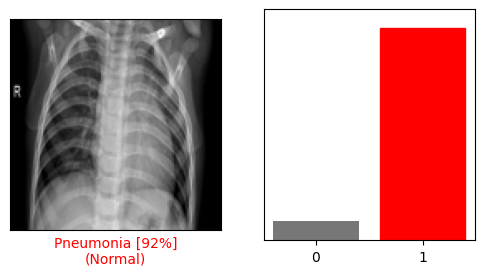

<Figure size 640x480 with 0 Axes>

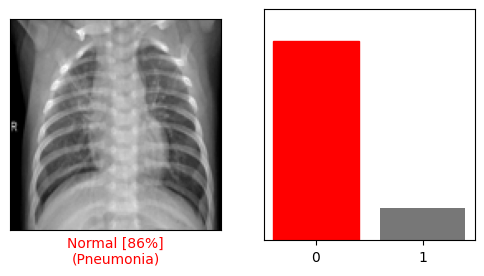

<Figure size 640x480 with 0 Axes>

In [ ]:
indices = np.array([indice for indice in list(range(len(predictions_binary_2))) if predictions_binary_2[indice] != test_y[indice]])

indices = np.random.choice(indices, 5, replace=False)

for indice in indices:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(indice, predictions_binary_2, predictions, test_y, test_X)
  plt.subplot(1,2,2)
  plot_value_array(indice, predictions_binary_2, predictions,  test_y)
  plt.show()
  plt.clf()

Y de una forma más general lo estudiamos para 25 de los pacientes.

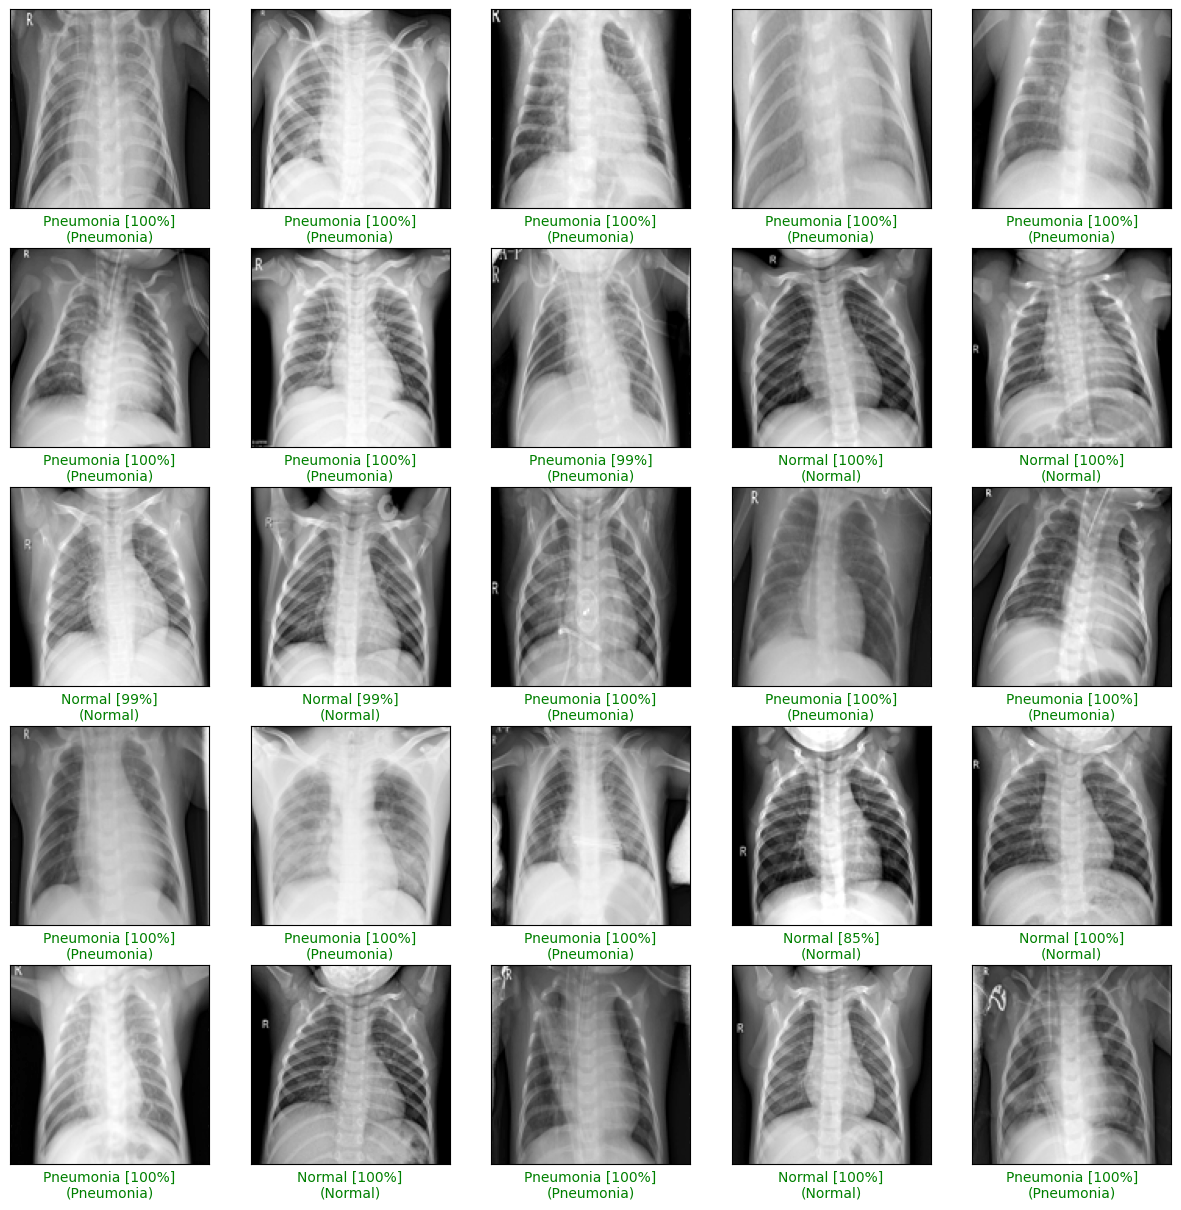

In [ ]:
# Selecciona 25 índices aleatorios
indices = np.random.choice(len(predictions), 25, replace=False)

# Crea una figura de 5x5
plt.figure(figsize=(15,15))

for i in range(5):
    for j in range(5):
        # Calcula el índice en la lista de índices aleatorios
        index = i * 5 + j

        # Crea un subplot en la posición i, j
        plt.subplot(5, 5, index+1)

        # Llama a la función plot_image con el índice aleatorio
        plot_image(indices[index], predictions_binary_2, predictions, test_y, test_X)

# Muestra la figura
plt.show()

# 5. Explicabilidad




In [ ]:
def get_grad_model(model):
    # Asume que 'conv2d_2' es el nombre de la última capa convolucional
    last_conv_layer_name = "conv2d_35"
    grad_model = Model(inputs=[model.inputs],
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    return grad_model

# Función para generar el mapa de calor
# def generate_heatmap(img_array, model, class_idx):
#     grad_model = get_grad_model(model)

#     # Registro de los gradientes
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         print(predictions)
#         loss = predictions[0, 0].numpy()
#         print(loss)

#     # Gradientes con respecto a la salida de la última capa convolucional
#     grads = tape.gradient(loss, conv_outputs)

#     # Ponderación de los canales por los gradientes
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_outputs = conv_outputs[0]
#     heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

#     # Aplicación de ReLU y normalización del mapa de calor
#     heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
#     return heatmap
def generate_heatmap(img_array, model, class_idx):
    grad_model = get_grad_model(model)  # Asumo que esta función prepara el modelo para devolver las salidas deseadas

    # Registro de los gradientes
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # print(predictions)
        if class_idx == 1:
            loss = predictions  # Uso directo de la predicción para la clase positiva
        else:
            loss = 1 - predictions  # Calculando la 'pérdida' para la clase negativa

    # Gradientes con respecto a la salida de la última capa convolucional
    grads = tape.gradient(loss, conv_outputs)

    # Ponderación de los canales por los gradientes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Aplicación de ReLU y normalización del mapa de calor
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Función para superponer el mapa de calor en la imagen original
def overlay_heatmap(heatmap, original_img, alpha=0.4, colormap=cm.viridis):
    # Redimensionamos el mapa de calor para que tenga el mismo tamaño que la imagen original
    heatmap_resized = np.uint8(255 * heatmap)
    heatmap_resized = cv2.resize(heatmap_resized, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superponemos el mapa de calor en la imagen original
    superimposed_img = heatmap_resized * alpha + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")

    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

NameError: name 'cm' is not defined

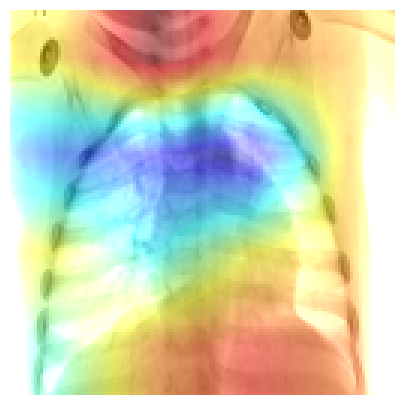

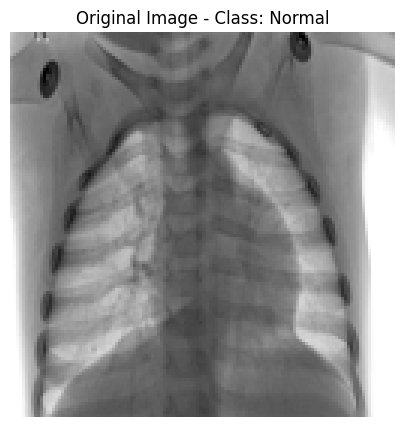

In [ ]:
# Asumiendo que test_X y test_y ya están definidos y preprocesados adecuadamente
# Elegir una imagen al azar del conjunto de test
index = random.randint(0, len(test_X)-1)
test_img = test_X[index]
test_label = test_y[index]

# La imagen de test ya debería estar en el formato correcto (128, 128, 1) y normalizada
# Sin embargo, necesitamos expandir las dimensiones para que tenga la forma (1, 128, 128, 1)
test_img_expanded = np.expand_dims(test_img, axis=0)

# Asumiendo que tienes un modelo ya entrenado y las funciones necesarias definidas
# Genera el mapa de calor para la clase predicha por el modelo
class_idx = predictions_binary_1[index][0] # Usa la clase con la mayor probabilidad predicha
# print(class_idx)

# Genera el mapa de calor
heatmap = generate_heatmap(test_img_expanded, binary_model, class_idx)

# La imagen original debe ser convertida de vuelta para visualización si fue alterada
# Convertir la imagen de prueba de vuelta a un rango [0,255] y a color RGB si es necesario
original_img = test_img.squeeze()  # Remover el eje de canal si está presente
# Sin invertir los colores después de escalar
original_img = (test_img.squeeze() * 255).astype(np.uint8)  # Si la invertiste durante el preprocesamiento
original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)  # Convertir a RGB si es necesario

# Superponer el mapa de calor en la imagen original y visualizar
overlay_heatmap(heatmap, original_img, alpha=0.5)

# Mostrar la imagen original al lado para comparar
plt.figure(figsize=(5, 5))
plt.imshow(original_img)
plt.title(f"Original Image - Real Class: {class_names[test_label]}, Predicter Class: {class_names[class_idx]}")
plt.axis('off')
plt.show()